# NB 03: Field vs Lab Fitness × Conservation

Test whether field-relevant fitness effects predict pangenome conservation
better than lab-only effects in *Desulfovibrio vulgaris* Hildenborough.

Analyses:
1. Condition-class fitness profiles per gene
2. Conservation by condition importance (core % comparison)
3. Specificity analysis: field-specific vs lab-specific vs universal genes
4. Logistic regression: `is_core ~ mean_field_fitness + mean_lab_fitness`
5. ROC analysis: compare AUC for predicting core status

**Run locally** — uses cached data from upstream projects + NB02 output.

**Outputs**: 4 figures in `figures/`, statistical test results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [2]:
# Fitness matrix: 2741 genes x 757 experiments
fitness = pd.read_csv(
    '../../fitness_modules/data/matrices/DvH_fitness_matrix.csv',
    index_col=0
)
print(f"Fitness matrix: {fitness.shape[0]} genes x {fitness.shape[1]} experiments")

# Experiment classification from NB02
exp_class = pd.read_csv(DATA_DIR / 'experiment_classification.csv')
print(f"Experiment classification: {len(exp_class)} experiments")

# Pangenome link (DvH only)
link = pd.read_csv(
    '../../conservation_vs_fitness/data/fb_pangenome_link.tsv',
    sep='\t'
)
link_dvh = link[link['orgId'] == 'DvH'].copy()
print(f"Pangenome link (DvH): {len(link_dvh)} genes")

# Essential genes (DvH only)
essentials = pd.read_csv(
    '../../conservation_vs_fitness/data/essential_genes.tsv',
    sep='\t', dtype={'gene': str}
)
ess_dvh = essentials[essentials['orgId'] == 'DvH'].copy()
print(f"Essential genes (DvH): {len(ess_dvh)} total, "
      f"{ess_dvh['is_essential'].sum()} essential")

Fitness matrix: 2741 genes x 757 experiments
Experiment classification: 757 experiments


Pangenome link (DvH): 3206 genes
Essential genes (DvH): 3403 total, 678 essential


In [3]:
# Build gene-level table with conservation status
# Map locusId -> is_core
conservation = link_dvh[['locusId', 'is_core', 'is_auxiliary', 'is_singleton']].copy()
conservation['locusId'] = conservation['locusId'].astype(int)

# Convert boolean columns: handle string 'True'/'False' or actual bools
for col in ['is_core', 'is_auxiliary', 'is_singleton']:
    if conservation[col].dtype == object:
        conservation[col] = conservation[col].map({'True': True, 'False': False}).astype(bool)
    else:
        conservation[col] = conservation[col].fillna(False).astype(bool)

# Essentiality
essentiality = ess_dvh[['locusId', 'is_essential', 'gene_length']].copy()
essentiality['locusId'] = essentiality['locusId'].astype(int)
if essentiality['is_essential'].dtype == object:
    essentiality['is_essential'] = essentiality['is_essential'].map({'True': True, 'False': False}).astype(bool)
else:
    essentiality['is_essential'] = essentiality['is_essential'].fillna(False).astype(bool)

# Merge
gene_info = conservation.merge(essentiality, on='locusId', how='outer')

# Fill NaN in boolean columns after outer merge
for col in ['is_core', 'is_auxiliary', 'is_singleton', 'is_essential']:
    gene_info[col] = gene_info[col].fillna(False).astype(bool)

print(f"Gene info table: {len(gene_info)} genes")
print(f"  With conservation: {conservation['locusId'].nunique()}")
print(f"  With essentiality: {essentiality['locusId'].nunique()}")
print(f"  Core: {gene_info['is_core'].sum()}, Auxiliary: {gene_info['is_auxiliary'].sum()}")

Gene info table: 3403 genes
  With conservation: 3206
  With essentiality: 3403
  Core: 2623, Auxiliary: 583


## 2. Compute Condition-Class Fitness Profiles

In [4]:
# Map experiments to categories
exp_to_cat = exp_class.set_index('expName')['category'].to_dict()
exp_to_broad = exp_class.set_index('expName')['broad_category'].to_dict()

# Group experiment columns by category
cat_experiments = {}
for exp_name in fitness.columns:
    cat = exp_to_cat.get(exp_name, 'unknown')
    cat_experiments.setdefault(cat, []).append(exp_name)

broad_experiments = {}
for exp_name in fitness.columns:
    bcat = exp_to_broad.get(exp_name, 'unknown')
    broad_experiments.setdefault(bcat, []).append(exp_name)

print("Experiments per category:")
for cat in ['field-core', 'field-stress', 'heavy-metals', 'lab-nutrient', 'lab-antibiotic', 'lab-other']:
    n = len(cat_experiments.get(cat, []))
    print(f"  {cat:20s}: {n:4d}")
print()
print("Experiments per broad category:")
for bcat in ['field', 'lab']:
    n = len(broad_experiments.get(bcat, []))
    print(f"  {bcat:20s}: {n:4d}")

Experiments per category:
  field-core          :  204
  field-stress        :   78
  heavy-metals        :   55
  lab-nutrient        :  237
  lab-antibiotic      :   43
  lab-other           :  140

Experiments per broad category:
  field               :  337
  lab                 :  420


In [5]:
# Compute mean fitness per gene per category
categories = ['field-core', 'field-stress', 'heavy-metals',
              'lab-nutrient', 'lab-antibiotic', 'lab-other']

cat_fitness = pd.DataFrame(index=fitness.index)
for cat in categories:
    exps = cat_experiments.get(cat, [])
    if len(exps) > 0:
        cat_fitness[f'mean_{cat}'] = fitness[exps].mean(axis=1)
        cat_fitness[f'min_{cat}'] = fitness[exps].min(axis=1)
        cat_fitness[f'n_sick_{cat}'] = (fitness[exps] < -2).sum(axis=1)
    else:
        cat_fitness[f'mean_{cat}'] = np.nan
        cat_fitness[f'min_{cat}'] = np.nan
        cat_fitness[f'n_sick_{cat}'] = 0

# Broad categories
for bcat in ['field', 'lab']:
    exps = broad_experiments.get(bcat, [])
    if len(exps) > 0:
        cat_fitness[f'mean_{bcat}'] = fitness[exps].mean(axis=1)
        cat_fitness[f'min_{bcat}'] = fitness[exps].min(axis=1)
        cat_fitness[f'n_sick_{bcat}'] = (fitness[exps] < -2).sum(axis=1)

cat_fitness.index.name = 'locusId'
print(f"Category fitness profiles: {cat_fitness.shape}")
cat_fitness.head()

Category fitness profiles: (2741, 24)


,mean_field-core,min_field-core,n_sick_field-core,mean_field-stress,min_field-stress,n_sick_field-stress,mean_heavy-metals,min_heavy-metals,n_sick_heavy-metals,mean_lab-nutrient,...,n_sick_lab-antibiotic,mean_lab-other,min_lab-other,n_sick_lab-other,mean_field,min_field,n_sick_field,mean_lab,min_lab,n_sick_lab
locusId,,,,,,,,,,,,,,,,,,,,,
11399142,0.161748,-0.900859,0,-0.149401,-1.856763,0,0.252173,-0.325470,0,0.118006,...,0,0.118359,-0.372419,0,0.104489,-1.856763,0,0.103934,-1.025641,0
11399143,0.078384,-0.446447,0,-0.008099,-0.328688,0,-0.000568,-0.415060,0,-0.086369,...,0,0.025558,-0.405454,0,0.045482,-0.446447,0,-0.039500,-3.100285,4
11399144,0.004340,-0.298026,0,-0.001873,-0.351730,0,-0.034162,-0.270753,0,0.036543,...,0,0.020235,-0.520151,0,-0.003382,-0.351730,0,0.033473,-0.520151,0
11399145,-0.150467,-0.880559,0,-0.165261,-0.582534,0,-0.155718,-0.649275,0,-0.207782,...,0,-0.145328,-0.690790,0,-0.154748,-0.880559,0,-0.187044,-1.076413,0
11399147,-0.420042,-6.170200,30,-0.023153,-1.724684,0,-0.076701,-1.114216,0,-0.184973,...,0,0.040906,-1.162757,0,-0.272146,-6.170200,30,-0.084845,-4.682494,5


In [6]:
# Merge fitness profiles with gene info
cat_fitness_reset = cat_fitness.reset_index()
cat_fitness_reset['locusId'] = cat_fitness_reset['locusId'].astype(int)

gene_data = gene_info.merge(cat_fitness_reset, on='locusId', how='inner')

# Identify essential genes excluded by inner merge (no fitness data)
essential_excluded = gene_info[
    (gene_info['is_essential']) &
    (~gene_info['locusId'].isin(gene_data['locusId']))
]
n_ess_excluded = len(essential_excluded)
n_ess_excluded_core = essential_excluded['is_core'].sum()

print(f"Combined gene data: {len(gene_data)} genes (non-essential with fitness data)")
print(f"  Core: {gene_data['is_core'].sum()}")
print(f"  Auxiliary: {(~gene_data['is_core']).sum()}")
print(f"  Essential: {gene_data['is_essential'].sum()}")
print()
print(f"NOTE: {n_ess_excluded} essential genes excluded (no fitness data in RB-TnSeq)")
print(f"  Of excluded essentials: {n_ess_excluded_core}/{n_ess_excluded} core "
      f"({n_ess_excluded_core/n_ess_excluded*100:.1f}%)")
print(f"  These genes lack transposon mutants, so fitness effects cannot be measured.")
print(f"  Their high core fraction ({n_ess_excluded_core/n_ess_excluded*100:.1f}%) is "
      f"above the non-essential baseline ({gene_data['is_core'].mean()*100:.1f}%).")

Combined gene data: 2725 genes (non-essential with fitness data)
  Core: 2080
  Auxiliary: 645
  Essential: 0

NOTE: 678 essential genes excluded (no fitness data in RB-TnSeq)
  Of excluded essentials: 543/678 core (80.1%)
  These genes lack transposon mutants, so fitness effects cannot be measured.
  Their high core fraction (80.1%) is above the non-essential baseline (76.3%).


## 3. Conservation by Condition Importance

For genes with strong negative fitness (< -2) in each category,
compare core genome fraction.

In [7]:
from statsmodels.stats.multitest import multipletests

FITNESS_THRESHOLD = -2  # strong fitness defect

# For each category, find genes with at least one experiment where fitness < -2
importance_results = []

for cat in categories:
    col = f'n_sick_{cat}'
    if col not in gene_data.columns:
        continue
    important_genes = gene_data[gene_data[col] > 0]
    if len(important_genes) == 0:
        continue
    
    n_total = len(important_genes)
    n_core = important_genes['is_core'].sum()
    core_pct = n_core / n_total * 100 if n_total > 0 else 0
    
    importance_results.append({
        'category': cat,
        'n_important': n_total,
        'n_core': int(n_core),
        'core_pct': core_pct
    })

# Add baseline: all genes with fitness data
n_all = len(gene_data)
n_all_core = gene_data['is_core'].sum()
importance_results.append({
    'category': 'all_genes',
    'n_important': n_all,
    'n_core': int(n_all_core),
    'core_pct': n_all_core / n_all * 100
})

# Add essential genes (excluded from fitness analysis) for context
importance_results.append({
    'category': 'essential (no fitness)',
    'n_important': n_ess_excluded,
    'n_core': int(n_ess_excluded_core),
    'core_pct': n_ess_excluded_core / n_ess_excluded * 100 if n_ess_excluded > 0 else 0
})

imp_df = pd.DataFrame(importance_results)

# Fisher exact tests: each category vs all_genes baseline, with BH-FDR correction
baseline_core = int(n_all_core)
baseline_noncore = n_all - baseline_core
pvals = []
odds_ratios = []
test_cats = []

for _, row in imp_df.iterrows():
    if row['category'] in ('all_genes', 'essential (no fitness)'):
        continue
    table = [
        [int(row['n_core']), int(row['n_important'] - row['n_core'])],
        [baseline_core, baseline_noncore]
    ]
    odds, pval = stats.fisher_exact(table)
    pvals.append(pval)
    odds_ratios.append(odds)
    test_cats.append(row['category'])

_, fdr_pvals, _, _ = multipletests(pvals, method='fdr_bh')

print("Conservation by condition importance (fitness < -2):")
print(imp_df.to_string(index=False))
print()
print("Fisher exact tests vs all-genes baseline (BH-FDR corrected):")
for cat, odds, pval, fdr in zip(test_cats, odds_ratios, pvals, fdr_pvals):
    sig = "*" if fdr < 0.05 else ""
    print(f"  {cat:20s}: OR={odds:.2f}, p={pval:.4g}, q={fdr:.4g} {sig}")

Conservation by condition importance (fitness < -2):
              category  n_important  n_core  core_pct
            field-core          376     310 82.446809
          field-stress          298     249 83.557047
          heavy-metals          198     141 71.212121
          lab-nutrient          452     368 81.415929
        lab-antibiotic          109      80 73.394495
             lab-other          292     238 81.506849
             all_genes         2725    2080 76.330275
essential (no fitness)          678     543 80.088496

Fisher exact tests vs all-genes baseline (BH-FDR corrected):
  field-core          : OR=1.46, p=0.008739, q=0.02622 *
  field-stress        : OR=1.58, p=0.004579, q=0.02622 *
  heavy-metals        : OR=0.77, p=0.1205, q=0.1446 
  lab-nutrient        : OR=1.36, p=0.01838, q=0.03677 *
  lab-antibiotic      : OR=0.86, p=0.4915, q=0.4915 
  lab-other           : OR=1.37, p=0.04869, q=0.07304 


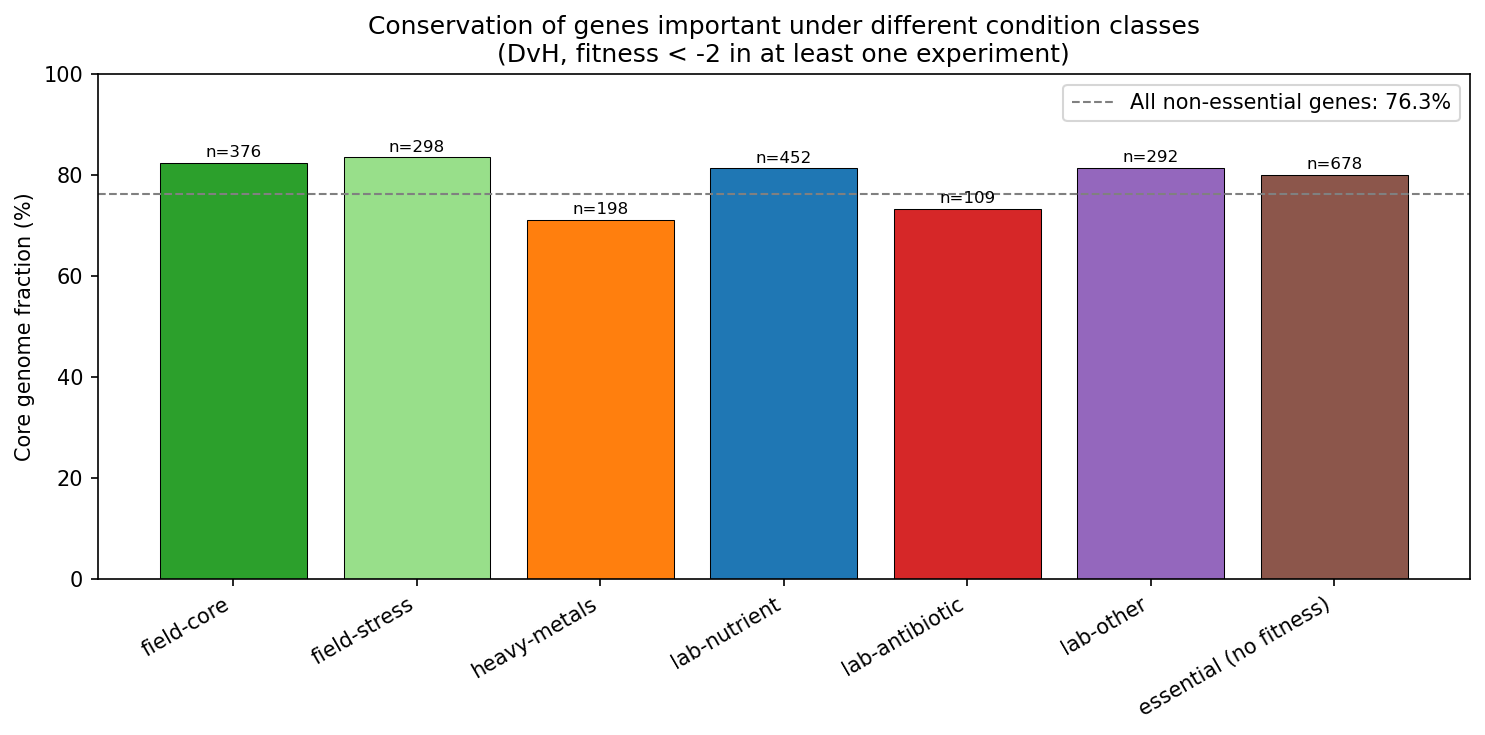

In [8]:
# Figure 1: Bar chart of core % for genes important in each condition category
fig, ax = plt.subplots(figsize=(10, 5))

# Include essential genes as a separate bar
plot_data = imp_df[~imp_df['category'].isin(['all_genes'])].copy()
baseline_pct = imp_df[imp_df['category'] == 'all_genes']['core_pct'].iloc[0]

colors = {
    'field-core': '#2ca02c',
    'field-stress': '#98df8a',
    'heavy-metals': '#ff7f0e',
    'lab-nutrient': '#1f77b4',
    'lab-antibiotic': '#d62728',
    'lab-other': '#9467bd',
    'essential (no fitness)': '#8c564b',
}

bars = ax.bar(
    range(len(plot_data)),
    plot_data['core_pct'],
    color=[colors.get(c, '#7f7f7f') for c in plot_data['category']],
    edgecolor='black', linewidth=0.5
)

# Add count labels
for i, (_, row) in enumerate(plot_data.iterrows()):
    ax.text(i, row['core_pct'] + 0.5, f"n={row['n_important']}",
            ha='center', va='bottom', fontsize=8)

# Baseline line
ax.axhline(baseline_pct, color='gray', linestyle='--', linewidth=1,
           label=f'All non-essential genes: {baseline_pct:.1f}%')

ax.set_xticks(range(len(plot_data)))
ax.set_xticklabels(plot_data['category'], rotation=30, ha='right')
ax.set_ylabel('Core genome fraction (%)')
ax.set_title('Conservation of genes important under different condition classes\n'
             '(DvH, fitness < -2 in at least one experiment)')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_conservation_by_condition_class.png')
plt.show()

## 4. Specificity Analysis

Identify genes that are:
- **Field-specific**: fitness < -2 in field conditions, fitness > -1 in lab
- **Lab-specific**: fitness < -2 in lab conditions, fitness > -1 in field
- **Universally important**: fitness < -2 in both

In [9]:
# Use min fitness across broad categories
gene_data['field_sick'] = gene_data['min_field'] < -2
gene_data['lab_sick'] = gene_data['min_lab'] < -2
gene_data['field_ok'] = gene_data['min_field'] > -1
gene_data['lab_ok'] = gene_data['min_lab'] > -1

# Classify specificity
def classify_specificity(row):
    if row['field_sick'] and row['lab_sick']:
        return 'universal'
    elif row['field_sick'] and row['lab_ok']:
        return 'field-specific'
    elif row['lab_sick'] and row['field_ok']:
        return 'lab-specific'
    elif row['field_sick']:
        return 'field-biased'
    elif row['lab_sick']:
        return 'lab-biased'
    else:
        return 'neutral'

gene_data['specificity'] = gene_data.apply(classify_specificity, axis=1)

print("Gene specificity classification:")
print(gene_data['specificity'].value_counts())
print()

# Core fraction per specificity class
spec_summary = gene_data.groupby('specificity').agg(
    n_genes=('locusId', 'count'),
    n_core=('is_core', 'sum'),
).reset_index()
spec_summary['core_pct'] = spec_summary['n_core'] / spec_summary['n_genes'] * 100
spec_summary

Gene specificity classification:
specificity
neutral           2083
universal          352
lab-biased          99
field-biased        89
field-specific      52
lab-specific        50
Name: count, dtype: int64



,specificity,n_genes,n_core,core_pct
0,field-biased,89,74,83.146067
1,field-specific,52,46,88.461538
2,lab-biased,99,79,79.797980
3,lab-specific,50,48,96.000000
4,neutral,2083,1552,74.507921
5,universal,352,281,79.829545


In [10]:
# Statistical tests: field-specific vs lab-specific core fraction
field_spec = gene_data[gene_data['specificity'] == 'field-specific']
lab_spec = gene_data[gene_data['specificity'] == 'lab-specific']
universal = gene_data[gene_data['specificity'] == 'universal']

print("Fisher exact tests (core vs non-core):")
print()

# Field-specific vs lab-specific
if len(field_spec) > 0 and len(lab_spec) > 0:
    table = [
        [int(field_spec['is_core'].sum()), int((~field_spec['is_core']).sum())],
        [int(lab_spec['is_core'].sum()), int((~lab_spec['is_core']).sum())]
    ]
    odds, pval = stats.fisher_exact(table)
    print(f"Field-specific vs Lab-specific:")
    print(f"  Field-specific: {field_spec['is_core'].sum()}/{len(field_spec)} core "
          f"({field_spec['is_core'].mean()*100:.1f}%)")
    print(f"  Lab-specific:   {lab_spec['is_core'].sum()}/{len(lab_spec)} core "
          f"({lab_spec['is_core'].mean()*100:.1f}%)")
    print(f"  OR={odds:.2f}, p={pval:.4g}")
    print()

# Universal vs neutral
neutral = gene_data[gene_data['specificity'] == 'neutral']
if len(universal) > 0 and len(neutral) > 0:
    table = [
        [int(universal['is_core'].sum()), int((~universal['is_core']).sum())],
        [int(neutral['is_core'].sum()), int((~neutral['is_core']).sum())]
    ]
    odds, pval = stats.fisher_exact(table)
    print(f"Universal vs Neutral:")
    print(f"  Universal: {universal['is_core'].sum()}/{len(universal)} core "
          f"({universal['is_core'].mean()*100:.1f}%)")
    print(f"  Neutral:   {neutral['is_core'].sum()}/{len(neutral)} core "
          f"({neutral['is_core'].mean()*100:.1f}%)")
    print(f"  OR={odds:.2f}, p={pval:.4g}")

Fisher exact tests (core vs non-core):

Field-specific vs Lab-specific:
  Field-specific: 46/52 core (88.5%)
  Lab-specific:   48/50 core (96.0%)
  OR=0.32, p=0.2699

Universal vs Neutral:
  Universal: 281/352 core (79.8%)
  Neutral:   1552/2083 core (74.5%)
  OR=1.35, p=0.0326


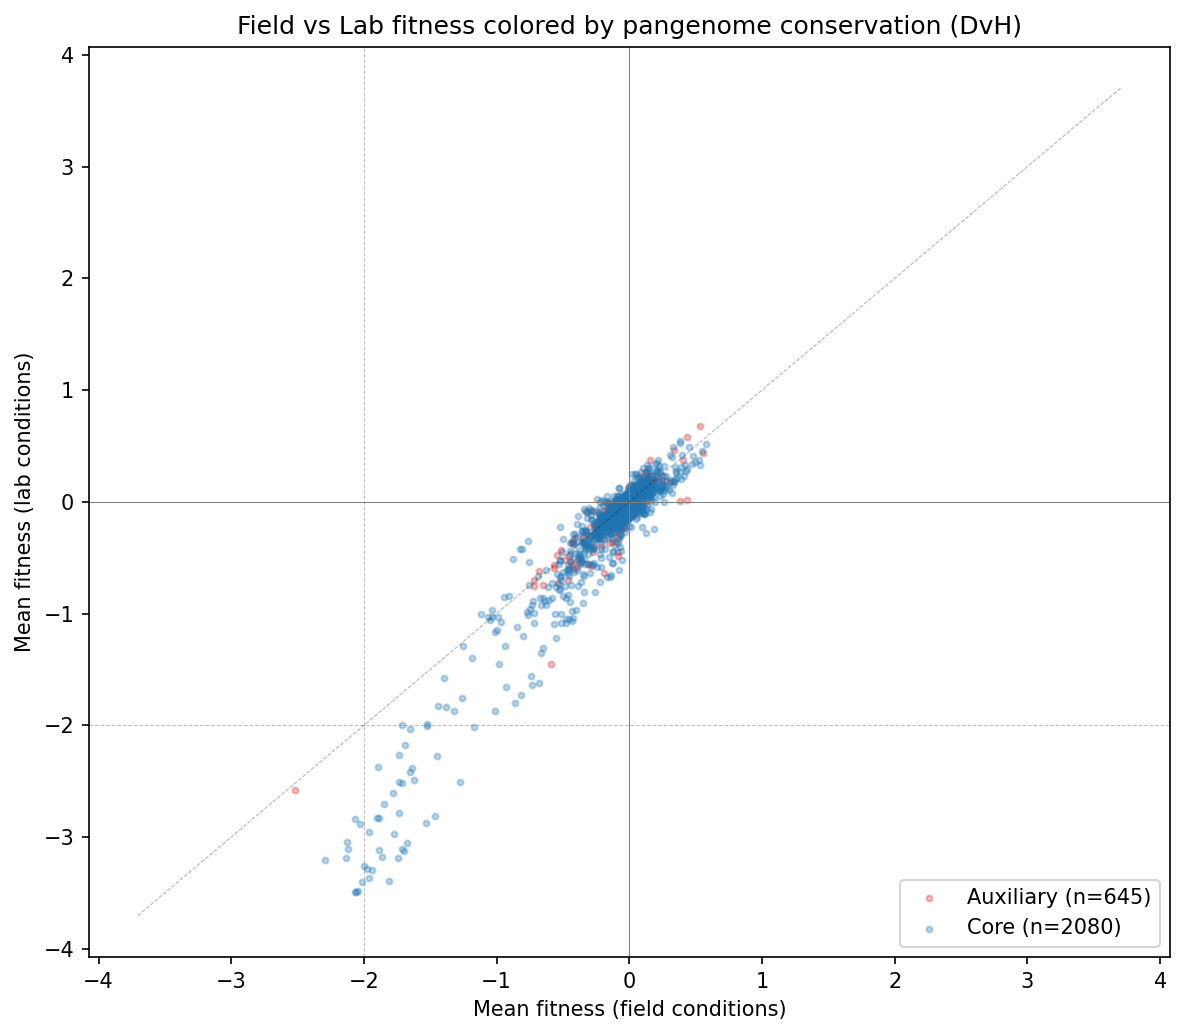

In [11]:
# Figure 2: Scatter of field fitness vs lab fitness colored by core/accessory
fig, ax = plt.subplots(figsize=(8, 7))

# Plot neutral genes first (background)
mask_core = gene_data['is_core'].astype(bool)
mask_aux = ~mask_core

ax.scatter(
    gene_data.loc[mask_aux, 'mean_field'],
    gene_data.loc[mask_aux, 'mean_lab'],
    alpha=0.3, s=8, c='#d62728', label=f'Auxiliary (n={mask_aux.sum()})',
    rasterized=True
)
ax.scatter(
    gene_data.loc[mask_core, 'mean_field'],
    gene_data.loc[mask_core, 'mean_lab'],
    alpha=0.3, s=8, c='#1f77b4', label=f'Core (n={mask_core.sum()})',
    rasterized=True
)

# Reference lines
ax.axhline(0, color='gray', linewidth=0.5, linestyle='-')
ax.axvline(0, color='gray', linewidth=0.5, linestyle='-')
ax.axhline(-2, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
ax.axvline(-2, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)

# Diagonal
lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]),
          abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
ax.plot([-lim, lim], [-lim, lim], 'k--', linewidth=0.5, alpha=0.3)

ax.set_xlabel('Mean fitness (field conditions)')
ax.set_ylabel('Mean fitness (lab conditions)')
ax.set_title('Field vs Lab fitness colored by pangenome conservation (DvH)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_field_vs_lab_specificity.png')
plt.show()

## 5. Logistic Regression

`is_core ~ mean_field_fitness + mean_lab_fitness + gene_length`

Which fitness dimension predicts conservation?

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare data for logistic regression
# Drop rows with missing values
reg_data = gene_data[['is_core', 'mean_field', 'mean_lab', 'gene_length']].dropna().copy()
reg_data['is_core'] = reg_data['is_core'].astype(int)
print(f"Regression data: {len(reg_data)} genes")

# Features
X = reg_data[['mean_field', 'mean_lab', 'gene_length']].values
y = reg_data['is_core'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit full model
lr_full = LogisticRegression(max_iter=1000)
lr_full.fit(X_scaled, y)

print(f"\nFull model (field + lab + gene_length):")
feature_names = ['mean_field', 'mean_lab', 'gene_length']
for name, coef in zip(feature_names, lr_full.coef_[0]):
    print(f"  {name:20s}: coef = {coef:.4f}")
print(f"  Intercept: {lr_full.intercept_[0]:.4f}")

# AUC
y_prob_full = lr_full.predict_proba(X_scaled)[:, 1]
auc_full = roc_auc_score(y, y_prob_full)
print(f"  AUC = {auc_full:.4f}")

Regression data: 2725 genes

Full model (field + lab + gene_length):
  mean_field          : coef = 0.3795
  mean_lab            : coef = -0.7421
  gene_length         : coef = 0.4340
  Intercept: 1.2535
  AUC = 0.6491


In [13]:
# Compare models: field-only, lab-only, combined
# Use 10-fold cross-validated AUC instead of in-sample AUC
from sklearn.model_selection import cross_val_score

models = {}

# Field-only
X_field = reg_data[['mean_field']].values
X_field_s = StandardScaler().fit_transform(X_field)
lr_field = LogisticRegression(max_iter=1000)
lr_field.fit(X_field_s, y)
y_prob_field = lr_field.predict_proba(X_field_s)[:, 1]
auc_field_insample = roc_auc_score(y, y_prob_field)
cv_field = cross_val_score(LogisticRegression(max_iter=1000), X_field_s, y,
                           cv=10, scoring='roc_auc')
auc_field = cv_field.mean()
models['field_only'] = {'auc': auc_field, 'auc_insample': auc_field_insample,
                        'probs': y_prob_field, 'coef': lr_field.coef_[0][0],
                        'cv_std': cv_field.std()}

# Lab-only
X_lab = reg_data[['mean_lab']].values
X_lab_s = StandardScaler().fit_transform(X_lab)
lr_lab = LogisticRegression(max_iter=1000)
lr_lab.fit(X_lab_s, y)
y_prob_lab = lr_lab.predict_proba(X_lab_s)[:, 1]
auc_lab_insample = roc_auc_score(y, y_prob_lab)
cv_lab = cross_val_score(LogisticRegression(max_iter=1000), X_lab_s, y,
                         cv=10, scoring='roc_auc')
auc_lab = cv_lab.mean()
models['lab_only'] = {'auc': auc_lab, 'auc_insample': auc_lab_insample,
                      'probs': y_prob_lab, 'coef': lr_lab.coef_[0][0],
                      'cv_std': cv_lab.std()}

# Combined (field + lab)
X_both = reg_data[['mean_field', 'mean_lab']].values
X_both_s = StandardScaler().fit_transform(X_both)
lr_both = LogisticRegression(max_iter=1000)
lr_both.fit(X_both_s, y)
y_prob_both = lr_both.predict_proba(X_both_s)[:, 1]
auc_both_insample = roc_auc_score(y, y_prob_both)
cv_both = cross_val_score(LogisticRegression(max_iter=1000), X_both_s, y,
                          cv=10, scoring='roc_auc')
auc_both = cv_both.mean()
models['field_and_lab'] = {'auc': auc_both, 'auc_insample': auc_both_insample,
                           'probs': y_prob_both, 'cv_std': cv_both.std()}

# Full model CV
cv_full = cross_val_score(LogisticRegression(max_iter=1000), X_scaled, y,
                          cv=10, scoring='roc_auc')
auc_full_cv = cv_full.mean()

print("Model comparison (10-fold cross-validated AUC):")
print(f"  Field-only:      CV-AUC = {auc_field:.4f} +/- {cv_field.std():.4f}  (in-sample: {auc_field_insample:.4f})")
print(f"  Lab-only:        CV-AUC = {auc_lab:.4f} +/- {cv_lab.std():.4f}  (in-sample: {auc_lab_insample:.4f})")
print(f"  Field + Lab:     CV-AUC = {auc_both:.4f} +/- {cv_both.std():.4f}  (in-sample: {auc_both_insample:.4f})")
print(f"  Full (+ length): CV-AUC = {auc_full_cv:.4f} +/- {cv_full.std():.4f}  (in-sample: {auc_full:.4f})")

Model comparison (10-fold cross-validated AUC):
  Field-only:      CV-AUC = 0.5171 +/- 0.0522  (in-sample: 0.5155)
  Lab-only:        CV-AUC = 0.5310 +/- 0.0524  (in-sample: 0.5310)
  Field + Lab:     CV-AUC = 0.5484 +/- 0.0526  (in-sample: 0.5523)
  Full (+ length): CV-AUC = 0.6452 +/- 0.0680  (in-sample: 0.6491)


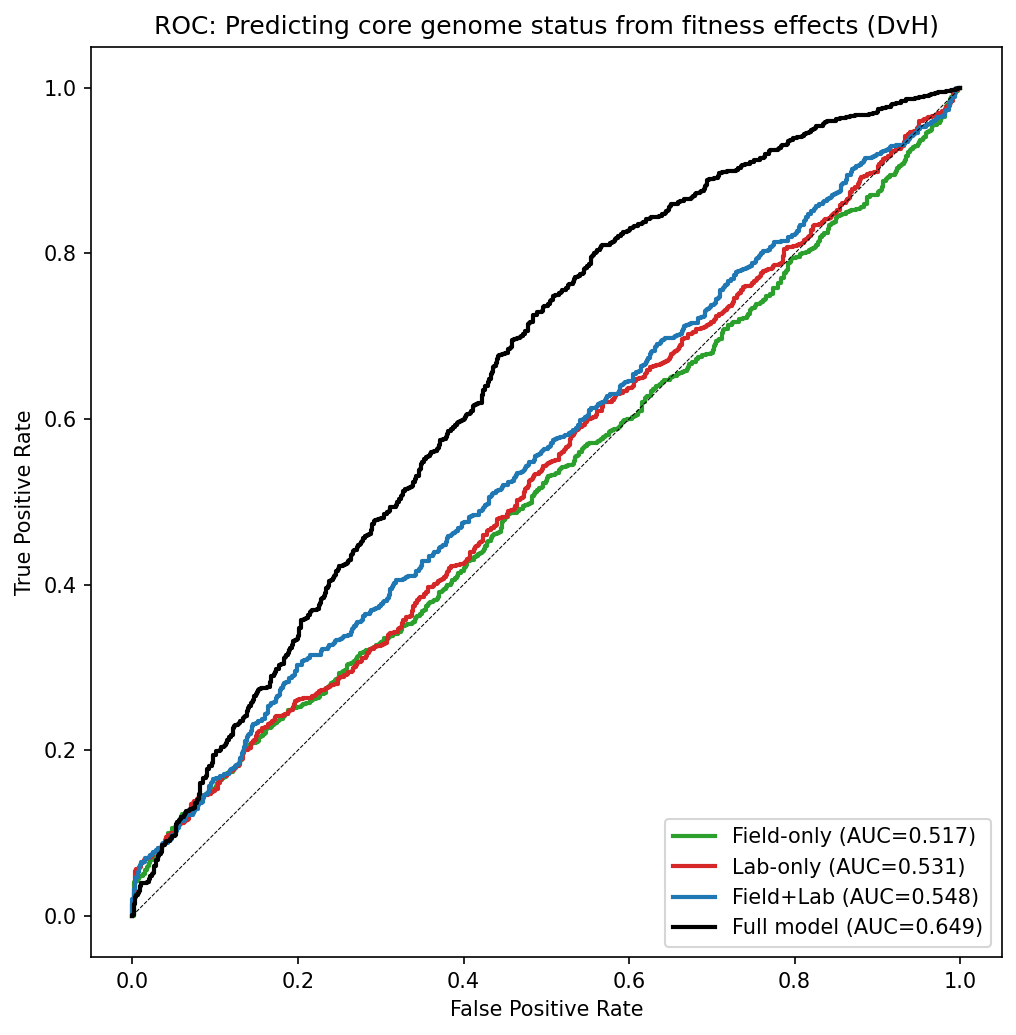

In [14]:
# Figure 3: ROC curves
fig, ax = plt.subplots(figsize=(7, 7))

# Field-only
fpr, tpr, _ = roc_curve(y, models['field_only']['probs'])
ax.plot(fpr, tpr, label=f"Field-only (AUC={auc_field:.3f})", color='#2ca02c', linewidth=2)

# Lab-only
fpr, tpr, _ = roc_curve(y, models['lab_only']['probs'])
ax.plot(fpr, tpr, label=f"Lab-only (AUC={auc_lab:.3f})", color='#d62728', linewidth=2)

# Combined
fpr, tpr, _ = roc_curve(y, models['field_and_lab']['probs'])
ax.plot(fpr, tpr, label=f"Field+Lab (AUC={auc_both:.3f})", color='#1f77b4', linewidth=2)

# Full
fpr, tpr, _ = roc_curve(y, y_prob_full)
ax.plot(fpr, tpr, label=f"Full model (AUC={auc_full:.3f})", color='black', linewidth=2)

# Diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=0.5)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC: Predicting core genome status from fitness effects (DvH)')
ax.legend(loc='lower right')
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_roc_conservation_prediction.png')
plt.show()

## 6. Condition Importance Heatmap

Gene importance across condition classes, stratified by conservation status.

In [15]:
# Compute fraction of genes with fitness < -2 in each category,
# split by core vs auxiliary
heatmap_data = []

for cat in categories:
    col = f'n_sick_{cat}'
    if col not in gene_data.columns:
        continue
    for status, label in [(True, 'Core'), (False, 'Auxiliary')]:
        subset = gene_data[gene_data['is_core'] == status]
        n_total = len(subset)
        n_sick = (subset[col] > 0).sum()
        heatmap_data.append({
            'category': cat,
            'conservation': label,
            'n_genes': n_total,
            'n_important': n_sick,
            'pct_important': n_sick / n_total * 100 if n_total > 0 else 0
        })

hm_df = pd.DataFrame(heatmap_data)

# Pivot for heatmap
hm_pivot = hm_df.pivot(index='category', columns='conservation', values='pct_important')
hm_pivot = hm_pivot.reindex(categories)

print("Percent of genes with fitness < -2, by category and conservation:")
hm_df

Percent of genes with fitness < -2, by category and conservation:


,category,conservation,n_genes,n_important,pct_important
0,field-core,Core,2080,310,14.903846
1,field-core,Auxiliary,645,66,10.232558
2,field-stress,Core,2080,249,11.971154
3,field-stress,Auxiliary,645,49,7.596899
4,heavy-metals,Core,2080,141,6.778846
5,heavy-metals,Auxiliary,645,57,8.837209
6,lab-nutrient,Core,2080,368,17.692308
7,lab-nutrient,Auxiliary,645,84,13.023256
8,lab-antibiotic,Core,2080,80,3.846154
9,lab-antibiotic,Auxiliary,645,29,4.496124


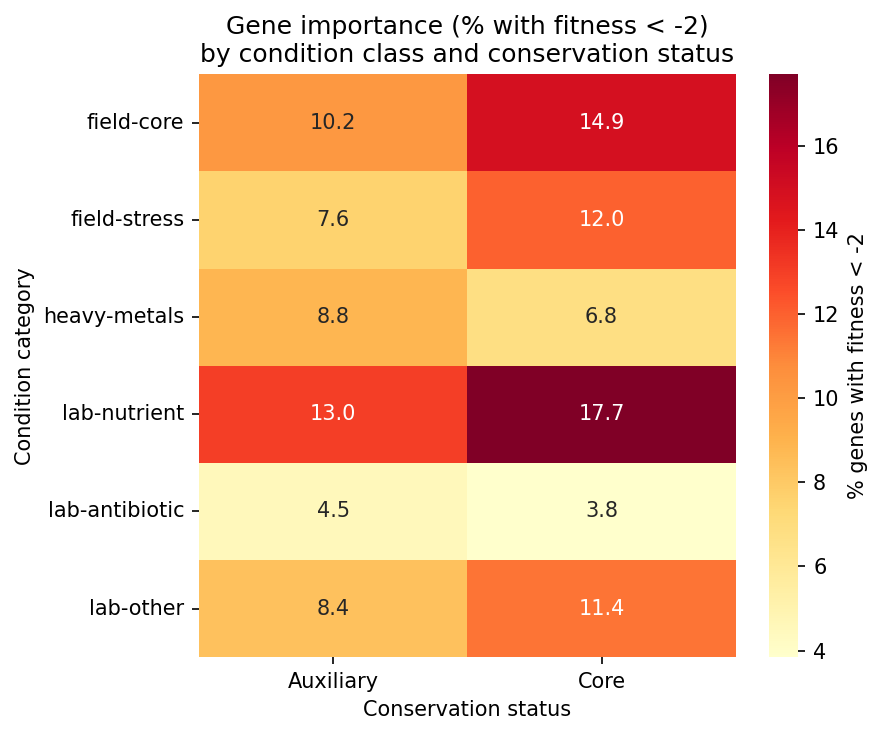

In [16]:
# Figure 4: Heatmap
fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(
    hm_pivot,
    annot=True, fmt='.1f', cmap='YlOrRd',
    ax=ax, cbar_kws={'label': '% genes with fitness < -2'}
)

ax.set_title('Gene importance (% with fitness < -2)\nby condition class and conservation status')
ax.set_ylabel('Condition category')
ax.set_xlabel('Conservation status')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_condition_importance_heatmap.png')
plt.show()

## 7. Threshold Sensitivity Analysis

Test whether results are robust to different fitness thresholds.

In [17]:
# Sensitivity analysis: vary the fitness threshold
thresholds = [-1.0, -1.5, -2.0, -3.0]
sensitivity_results = []

for thresh in thresholds:
    for cat in categories:
        col = f'min_{cat}' if f'min_{cat}' in gene_data.columns else None
        if col is None:
            continue
        important = gene_data[gene_data[col] < thresh]
        if len(important) == 0:
            continue
        n = len(important)
        n_core = important['is_core'].sum()
        sensitivity_results.append({
            'threshold': thresh,
            'category': cat,
            'n_important': n,
            'core_pct': n_core / n * 100
        })

sens_df = pd.DataFrame(sensitivity_results)
sens_pivot = sens_df.pivot(index='category', columns='threshold', values='core_pct')
sens_pivot = sens_pivot.reindex(categories)

print("Core % by condition class across fitness thresholds:")
print(sens_pivot.round(1).to_string())
print()

# Also show n counts
sens_n = sens_df.pivot(index='category', columns='threshold', values='n_important')
sens_n = sens_n.reindex(categories)
print("Gene counts:")
print(sens_n.to_string())

Core % by condition class across fitness thresholds:
threshold       -3.0  -2.0  -1.5  -1.0
category                              
field-core      84.4  82.4  81.9  79.0
field-stress    89.4  83.6  84.0  82.1
heavy-metals    70.6  71.2  76.7  76.7
lab-nutrient    83.5  81.4  81.0  79.5
lab-antibiotic  82.2  73.4  77.3  76.2
lab-other       85.2  81.5  80.1  77.5

Gene counts:
threshold       -3.0  -2.0  -1.5  -1.0
category                              
field-core       173   376   540   848
field-stress     170   298   401   614
heavy-metals      68   198   344   610
lab-nutrient     273   452   606   966
lab-antibiotic    45   109   172   307
lab-other        169   292   407   668


In [18]:
## 8. Summary

In [19]:
print("=" * 60)
print("FIELD VS LAB FITNESS x CONSERVATION SUMMARY")
print("=" * 60)
print()
print(f"Genes analyzed: {len(gene_data)} (non-essential with fitness data)")
print(f"  Core: {gene_data['is_core'].sum()} ({gene_data['is_core'].mean()*100:.1f}%)")
print(f"  Auxiliary: {(~gene_data['is_core']).sum()} ({(~gene_data['is_core']).mean()*100:.1f}%)")
print(f"  Essential genes excluded: {n_ess_excluded} ({n_ess_excluded_core/n_ess_excluded*100:.1f}% core)")
print()
print("Conservation by condition importance (fitness < -2):")
for _, row in imp_df.iterrows():
    print(f"  {row['category']:25s}: {row['core_pct']:.1f}% core (n={row['n_important']})")
print()
print("Gene specificity:")
for _, row in spec_summary.iterrows():
    print(f"  {row['specificity']:20s}: {row['core_pct']:.1f}% core (n={int(row['n_genes'])})")
print()
print("Logistic regression (10-fold CV AUC):")
print(f"  Field-only:      {auc_field:.4f} +/- {cv_field.std():.4f}")
print(f"  Lab-only:        {auc_lab:.4f} +/- {cv_lab.std():.4f}")
print(f"  Combined:        {auc_both:.4f} +/- {cv_both.std():.4f}")
print(f"  Full (+ length): {auc_full_cv:.4f} +/- {cv_full.std():.4f}")
print("=" * 60)

FIELD VS LAB FITNESS x CONSERVATION SUMMARY

Genes analyzed: 2725 (non-essential with fitness data)
  Core: 2080 (76.3%)
  Auxiliary: 645 (23.7%)
  Essential genes excluded: 678 (80.1% core)

Conservation by condition importance (fitness < -2):
  field-core               : 82.4% core (n=376)
  field-stress             : 83.6% core (n=298)
  heavy-metals             : 71.2% core (n=198)
  lab-nutrient             : 81.4% core (n=452)
  lab-antibiotic           : 73.4% core (n=109)
  lab-other                : 81.5% core (n=292)
  all_genes                : 76.3% core (n=2725)
  essential (no fitness)   : 80.1% core (n=678)

Gene specificity:
  field-biased        : 83.1% core (n=89)
  field-specific      : 88.5% core (n=52)
  lab-biased          : 79.8% core (n=99)
  lab-specific        : 96.0% core (n=50)
  neutral             : 74.5% core (n=2083)
  universal           : 79.8% core (n=352)

Logistic regression (10-fold CV AUC):
  Field-only:      0.5171 +/- 0.0522
  Lab-only:        0